In [1]:
%run ../replay.ipynb

In [2]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import gym
import pybullet_envs
import random
import numpy as np
import tensorflow as tf
import time
from gym.envs.registration import register
from IPython.display import clear_output
from itertools import count

In [3]:
random.seed(2212)
np.random.seed(2212)
tf.random.set_seed(2212)
tf.keras.backend.set_floatx('float64')

In [4]:
env = gym.make('HalfCheetah-v2')
print('observation_space:', env.observation_space.shape)
print('action_space:', env.action_space.shape)
print('action lower:', env.action_space.low)
print('action upper:', env.action_space.high)

observation_space: (17,)
action_space: (6,)
action lower: [-1. -1. -1. -1. -1. -1.]
action upper: [1. 1. 1. 1. 1. 1.]


In [5]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Lambda, concatenate

class Actor:
    def __init__(self, state_dim, action_dim, action_low, action_high):
        last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
        
        inputs = Input((state_dim,))
        hidden = Dense(256, activation='relu')(inputs)
        hidden = Dense(256, activation='relu')(hidden)
        outputs = Dense(action_dim, activation='tanh', kernel_initializer=last_init)(hidden)
        def rescale(x):
            return x * action_high
        outputs = Lambda(rescale)(outputs)
        
        self.model = Model(inputs, outputs)
        
        self.action_low = action_low
        self.action_high = action_high
        
        self.mu = 0.0
        self.sigma = 0.1
        
    def select(self, state, add_noise=True):
        states = np.expand_dims(state, axis=0)
        action = self.model(states)
        if add_noise:
            action += np.random.normal(self.mu, self.sigma, size=action.shape)
            
        action = np.clip(action, self.action_low, self.action_high)
        return action

In [6]:
class Critic:
    def __init__(self, state_dim, action_dim):
        state_in = Input((state_dim,))
        action_in = Input((action_dim,))
        concat = concatenate([state_in, action_in])
        hidden = Dense(256, activation='relu')(concat)
        hidden = Dense(256, activation='relu')(hidden)
        output = Dense(1, activation='linear')(hidden)
        
        self.model = Model([state_in, action_in], output)

In [7]:
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))
        
class Agent:
    def __init__(self, env):
        state_dim = np.squeeze(env.observation_space.shape)
        action_dim = np.squeeze(env.action_space.shape)
        
        self.state_dim, self.action_dim = state_dim, action_dim
        
        action_high = env.action_space.high
        action_low = env.action_space.low
        
        '''Initialize critic networks Qθ1, Qθ2, 
        and actor network πφ with random parameters θ1, θ2, φ'''
        self.critic_1 = Critic(state_dim, action_dim)
        self.critic_2 = Critic(state_dim, action_dim)
        self.actor = Actor(state_dim, action_dim, action_low, action_high)
        
        '''Initialize target networks θ1' ← θ1, θ2' ← θ2, φ' ← φ'''
        self.target_critic_1 = Critic(state_dim, action_dim)
        self.update(self.target_critic_1, self.critic_1, 1)
        
        self.target_critic_2 = Critic(state_dim, action_dim)
        self.update(self.target_critic_2, self.critic_2, 1)
        
        self.target_actor = Actor(state_dim, action_dim, action_low, action_high)
        self.update(self.target_actor, self.actor, 1)
        
        '''Initialize replay buffer B'''
        self.memory = Memory(1000000)
        self.batch_size = 256
        
        self.policy_noise = 0.2
        self.noise_clip = 0.5
        
        self.total_epochs = 0
        self.policy_update = 2
        
        self.gamma = 0.99
        
        self.actor_optimizer = tf.keras.optimizers.Adam(lr=1e-3)
        self.critic_1_optimizer = tf.keras.optimizers.Adam(lr=1e-3)
        self.critic_2_optimizer = tf.keras.optimizers.Adam(lr=1e-3)
        
        self.tau = 0.005
        
        self.start_timesteps = int(25e3)
        self.timesteps = 0
        
        self.env = env
        
    def update(self, target, src, tau=None):
        if tau == None:
            tau = self.tau
        if tau == 1:
            target.model.set_weights(src.model.get_weights())
        else:
            update_target(target.model.variables, src.model.variables, tau)
    
    @tf.function
    def update_actor(self, states):
        '''Update φ by the deterministic policy gradient:
            ∇φJ(φ) = N −1 P∇aQθ1(s, a)|a=πφ(s)∇φπφ(s)'''
        with tf.GradientTape() as tape:
            actions = self.actor.model(states)
            actor_loss = -tf.reduce_mean(self.critic_1.model([states, actions]))
            # minus sign to maximize critic value --> max(Q[i])
        actor_grad = tape.gradient(actor_loss, self.actor.model.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.model.trainable_variables))

    @tf.function
    def train(self, states, actions, rewards, next_states, not_dones):
        '''e ∼ clip(N (0, σ˜), −c, c)'''
        noise = tf.random.normal(actions.shape, 0, self.policy_noise, tf.float64)
        noise = tf.clip_by_value(noise, -self.noise_clip, self.noise_clip)

        '''a˜ ← πφ0 (s') + e'''
        next_action = self.target_actor.model(next_states)
        next_action = tf.clip_by_value(
            next_action + noise, 
            self.actor.action_low, 
            self.actor.action_high
        )

        '''y ← r + γ mini=1,2 Qθ(',i)(s', a˜)'''
        target_Q_1 = self.target_critic_1.model([next_states, next_action])
        target_Q_2 = self.target_critic_2.model([next_states, next_action])
        target_Q = rewards + self.gamma * tf.minimum(target_Q_1, target_Q_2) * not_dones
        
        '''Update critics θi ← argminθi N −1 P(y−Qθi(s, a))2'''
        with tf.GradientTape() as tape:
            Q_1 = self.critic_1.model([states, actions])
            loss = tf.reduce_mean(tf.square(target_Q - Q_1))
        grad = tape.gradient(loss, self.critic_1.model.trainable_variables)
        self.critic_1_optimizer.apply_gradients(zip(grad, self.critic_1.model.trainable_variables))

        with tf.GradientTape() as tape:
            Q_2 = self.critic_2.model([states, actions])
            loss = tf.reduce_mean(tf.square(target_Q - Q_2))
        grad = tape.gradient(loss, self.critic_2.model.trainable_variables)
        self.critic_2_optimizer.apply_gradients(zip(grad, self.critic_2.model.trainable_variables))
        
    def run(self, max_episode=100):
        history = []
        for ep in range(max_episode):
            state = env.reset()
            ep_reward = 0

            '''for t = 1 to T do'''
            for step in count():
                '''Select action with exploration noise a ∼ πφ(s) + e, e ∼ N (0, σ)'''
                if self.timesteps < self.start_timesteps:
                    action = self.env.action_space.sample()
                else:
                    action = self.actor.select(state)[0]
                self.timesteps += 1

                '''and observe reward r and new state s'''
                next_state, reward, done, _ = env.step(action)

                '''Store transition tuple (s, a, r, s') in B'''
                self.memory.add((state, action, reward, next_state, 1 - done))

                if len(self.memory.buffer) >= self.batch_size and self.timesteps > self.start_timesteps:
                    self.total_epochs += 1
                    samples = self.memory.replay(self.batch_size)

                    '''Sample mini-batch of N transitions (s, a, r, s') from B'''
                    states, actions, rewards, next_states, not_dones = samples
                    self.train(states, actions, rewards, next_states, not_dones)

                    '''if t mod d then'''
                    if self.total_epochs % self.policy_update == 0:
                        self.update_actor(states)

                        '''Update target networks:'''
                        '''θ'i ← τθi + (1 − τ )θ'i
                        φ' ← τφ + (1 − τ )φ`'''
                        self.update(self.target_critic_1, self.critic_1)
                        self.update(self.target_critic_2, self.critic_2)
                        self.update(self.target_actor, self.actor)

                ep_reward += reward

                if done:
                    break
                state = next_state

            history.append(ep_reward)
            print('Episode: {}, ep_reward: {}, step: {}'.format(ep, ep_reward, step + 1))

        return history

In [8]:
agent = Agent(env)

In [9]:
history = agent.run(3000)

Episode: 0, ep_reward: -374.97327749011725, step: 1000
Episode: 1, ep_reward: -265.6337870375549, step: 1000
Episode: 2, ep_reward: -242.7452596525802, step: 1000
Episode: 3, ep_reward: -356.5839071771658, step: 1000
Episode: 4, ep_reward: -172.61268171143564, step: 1000
Episode: 5, ep_reward: -195.94257300509324, step: 1000
Episode: 6, ep_reward: -357.1533649168387, step: 1000
Episode: 7, ep_reward: -257.75324851010566, step: 1000
Episode: 8, ep_reward: -266.5180690919722, step: 1000
Episode: 9, ep_reward: -193.44131481099254, step: 1000
Episode: 10, ep_reward: -302.79838739759157, step: 1000
Episode: 11, ep_reward: -234.1349272914188, step: 1000
Episode: 12, ep_reward: -286.4984101211923, step: 1000
Episode: 13, ep_reward: -321.9308171878257, step: 1000
Episode: 14, ep_reward: -254.32016255404085, step: 1000
Episode: 15, ep_reward: -167.58079920166142, step: 1000
Episode: 16, ep_reward: -481.95103754834344, step: 1000
Episode: 17, ep_reward: -353.65121822505944, step: 1000
Episode: 1

Episode: 150, ep_reward: 6026.097247243174, step: 1000
Episode: 151, ep_reward: 5632.269337428548, step: 1000
Episode: 152, ep_reward: 5953.971618405326, step: 1000
Episode: 153, ep_reward: 5896.286454437512, step: 1000
Episode: 154, ep_reward: 6001.916647021428, step: 1000
Episode: 155, ep_reward: 5922.100773038917, step: 1000
Episode: 156, ep_reward: 5820.915410880887, step: 1000
Episode: 157, ep_reward: 5771.9377980365225, step: 1000
Episode: 158, ep_reward: 6073.6620019416805, step: 1000
Episode: 159, ep_reward: 5896.373604492838, step: 1000
Episode: 160, ep_reward: 5903.350593925135, step: 1000
Episode: 161, ep_reward: 6097.571104040233, step: 1000
Episode: 162, ep_reward: 6073.0494776362975, step: 1000
Episode: 163, ep_reward: 5817.227093359482, step: 1000
Episode: 164, ep_reward: 6112.483634043485, step: 1000
Episode: 165, ep_reward: 6004.21075062994, step: 1000
Episode: 166, ep_reward: 6105.775589180128, step: 1000
Episode: 167, ep_reward: 5671.168933430662, step: 1000
Episode:

Episode: 300, ep_reward: 7419.559612744911, step: 1000
Episode: 301, ep_reward: 7570.508225326295, step: 1000
Episode: 302, ep_reward: 7502.135287010206, step: 1000
Episode: 303, ep_reward: 7348.702422573078, step: 1000
Episode: 304, ep_reward: 7466.071433500104, step: 1000
Episode: 305, ep_reward: 7627.808402142161, step: 1000
Episode: 306, ep_reward: 7547.983299346656, step: 1000
Episode: 307, ep_reward: 7359.8257885766625, step: 1000
Episode: 308, ep_reward: 7350.589656234544, step: 1000
Episode: 309, ep_reward: 7511.334333049823, step: 1000
Episode: 310, ep_reward: 7544.293802032451, step: 1000
Episode: 311, ep_reward: 7299.021977410971, step: 1000
Episode: 312, ep_reward: 7195.819490870616, step: 1000
Episode: 313, ep_reward: 7446.86858815874, step: 1000
Episode: 314, ep_reward: 7615.4365900778885, step: 1000
Episode: 315, ep_reward: 6501.454661184857, step: 1000
Episode: 316, ep_reward: 7066.1751093659705, step: 1000
Episode: 317, ep_reward: 7601.973044055504, step: 1000
Episode:

Episode: 449, ep_reward: 8013.809301064197, step: 1000
Episode: 450, ep_reward: 8063.674986601711, step: 1000
Episode: 451, ep_reward: 8213.450804658283, step: 1000
Episode: 452, ep_reward: 8234.433065914473, step: 1000
Episode: 453, ep_reward: 7721.81297897516, step: 1000
Episode: 454, ep_reward: 8299.970379152455, step: 1000
Episode: 455, ep_reward: 8257.136667586563, step: 1000
Episode: 456, ep_reward: 8286.028657097782, step: 1000
Episode: 457, ep_reward: 7685.777035911239, step: 1000
Episode: 458, ep_reward: 8316.084911008396, step: 1000
Episode: 459, ep_reward: 8005.41332765221, step: 1000
Episode: 460, ep_reward: 8174.223903752263, step: 1000
Episode: 461, ep_reward: 8120.1376857273335, step: 1000
Episode: 462, ep_reward: 8202.831900695164, step: 1000
Episode: 463, ep_reward: 8201.916075066976, step: 1000
Episode: 464, ep_reward: 7849.040867861427, step: 1000
Episode: 465, ep_reward: 1434.6554630122796, step: 1000
Episode: 466, ep_reward: 8050.017940907902, step: 1000
Episode: 4

Episode: 599, ep_reward: 8319.882386574805, step: 1000
Episode: 600, ep_reward: 8229.76061159045, step: 1000
Episode: 601, ep_reward: 8502.272080907062, step: 1000
Episode: 602, ep_reward: 8598.999051154571, step: 1000
Episode: 603, ep_reward: 8690.164567229876, step: 1000
Episode: 604, ep_reward: 8256.951085338298, step: 1000
Episode: 605, ep_reward: 8625.427322017378, step: 1000
Episode: 606, ep_reward: 8626.867641840312, step: 1000
Episode: 607, ep_reward: 8587.605348680556, step: 1000
Episode: 608, ep_reward: 8494.558972612082, step: 1000
Episode: 609, ep_reward: 8439.897296394865, step: 1000
Episode: 610, ep_reward: 8403.968679113937, step: 1000
Episode: 611, ep_reward: 8620.704153677136, step: 1000
Episode: 612, ep_reward: 8507.109466621503, step: 1000
Episode: 613, ep_reward: 8413.959233650872, step: 1000
Episode: 614, ep_reward: 8380.772292942593, step: 1000
Episode: 615, ep_reward: 8608.811280167705, step: 1000
Episode: 616, ep_reward: 8641.591812194778, step: 1000
Episode: 61

Episode: 749, ep_reward: 8616.35631345242, step: 1000
Episode: 750, ep_reward: 8327.652017198636, step: 1000
Episode: 751, ep_reward: 8642.04361734296, step: 1000
Episode: 752, ep_reward: 8561.18812476262, step: 1000
Episode: 753, ep_reward: 8796.024331660317, step: 1000
Episode: 754, ep_reward: 8194.954548128642, step: 1000
Episode: 755, ep_reward: 8740.522246898641, step: 1000
Episode: 756, ep_reward: 8388.76895164762, step: 1000
Episode: 757, ep_reward: 8853.649312932926, step: 1000
Episode: 758, ep_reward: 8440.236848635846, step: 1000
Episode: 759, ep_reward: 8737.59335215145, step: 1000
Episode: 760, ep_reward: 8673.940561237387, step: 1000
Episode: 761, ep_reward: 8800.423784828798, step: 1000
Episode: 762, ep_reward: 8624.451770443537, step: 1000
Episode: 763, ep_reward: 8601.033350677342, step: 1000
Episode: 764, ep_reward: 8558.80392145619, step: 1000
Episode: 765, ep_reward: 8556.731360420066, step: 1000
Episode: 766, ep_reward: 8597.535699247588, step: 1000
Episode: 767, ep

Episode: 899, ep_reward: 8593.395589950229, step: 1000
Episode: 900, ep_reward: 9144.280643386339, step: 1000
Episode: 901, ep_reward: 8770.954137827654, step: 1000
Episode: 902, ep_reward: 8874.327178530357, step: 1000
Episode: 903, ep_reward: 8851.554415972216, step: 1000
Episode: 904, ep_reward: 9100.3519335311, step: 1000
Episode: 905, ep_reward: 8931.856006480419, step: 1000
Episode: 906, ep_reward: 9067.269394217534, step: 1000
Episode: 907, ep_reward: 9023.058290768258, step: 1000
Episode: 908, ep_reward: 8622.68950736868, step: 1000
Episode: 909, ep_reward: 8942.17626063045, step: 1000
Episode: 910, ep_reward: 8707.579060798214, step: 1000
Episode: 911, ep_reward: 8759.267640543398, step: 1000
Episode: 912, ep_reward: 9237.03159188328, step: 1000
Episode: 913, ep_reward: 8890.517153301587, step: 1000
Episode: 914, ep_reward: 8725.421974439516, step: 1000
Episode: 915, ep_reward: 8742.848730718986, step: 1000
Episode: 916, ep_reward: 8905.448441594752, step: 1000
Episode: 917, e

Episode: 1048, ep_reward: 8916.289844909717, step: 1000
Episode: 1049, ep_reward: 9202.75162769364, step: 1000
Episode: 1050, ep_reward: 8969.937796063878, step: 1000
Episode: 1051, ep_reward: 9194.169498172392, step: 1000
Episode: 1052, ep_reward: 9199.57749105922, step: 1000
Episode: 1053, ep_reward: 8492.418828292759, step: 1000
Episode: 1054, ep_reward: 9088.909826389116, step: 1000
Episode: 1055, ep_reward: 9083.649811590594, step: 1000
Episode: 1056, ep_reward: 9036.219309132868, step: 1000
Episode: 1057, ep_reward: 8922.925302342457, step: 1000
Episode: 1058, ep_reward: 9045.25595862927, step: 1000
Episode: 1059, ep_reward: 9026.910194065273, step: 1000
Episode: 1060, ep_reward: 9185.31440927868, step: 1000
Episode: 1061, ep_reward: 8624.348277084808, step: 1000
Episode: 1062, ep_reward: 8819.765785749534, step: 1000
Episode: 1063, ep_reward: 8922.43333645297, step: 1000
Episode: 1064, ep_reward: 8897.652365102578, step: 1000
Episode: 1065, ep_reward: 8702.069633310526, step: 10

Episode: 1195, ep_reward: 9313.213998799583, step: 1000
Episode: 1196, ep_reward: 9192.987434800465, step: 1000
Episode: 1197, ep_reward: 8601.97573433223, step: 1000
Episode: 1198, ep_reward: 9012.716134787726, step: 1000
Episode: 1199, ep_reward: 9257.854073506469, step: 1000
Episode: 1200, ep_reward: 9102.430975953432, step: 1000
Episode: 1201, ep_reward: 9200.149520799709, step: 1000
Episode: 1202, ep_reward: 9397.036534131374, step: 1000
Episode: 1203, ep_reward: 9280.21485003459, step: 1000
Episode: 1204, ep_reward: 8921.670588433373, step: 1000
Episode: 1205, ep_reward: 9161.810773962521, step: 1000
Episode: 1206, ep_reward: 9164.851977698849, step: 1000
Episode: 1207, ep_reward: 9201.521669394526, step: 1000
Episode: 1208, ep_reward: 9333.29220235073, step: 1000
Episode: 1209, ep_reward: 9306.524103015345, step: 1000
Episode: 1210, ep_reward: 8883.949060526262, step: 1000
Episode: 1211, ep_reward: 8975.54335110913, step: 1000
Episode: 1212, ep_reward: 8996.682808322348, step: 1

Episode: 1342, ep_reward: 9272.436903282924, step: 1000
Episode: 1343, ep_reward: 9566.428157972367, step: 1000
Episode: 1344, ep_reward: 9310.44274324386, step: 1000
Episode: 1345, ep_reward: 8909.155920009947, step: 1000
Episode: 1346, ep_reward: 8763.105322134303, step: 1000
Episode: 1347, ep_reward: 9030.29817209138, step: 1000
Episode: 1348, ep_reward: 9175.662269461694, step: 1000
Episode: 1349, ep_reward: 9149.663612334049, step: 1000
Episode: 1350, ep_reward: 8923.211335918722, step: 1000
Episode: 1351, ep_reward: 8992.23832390725, step: 1000
Episode: 1352, ep_reward: 9547.576984798528, step: 1000
Episode: 1353, ep_reward: 9347.686144451447, step: 1000
Episode: 1354, ep_reward: 9106.526904779737, step: 1000
Episode: 1355, ep_reward: 9533.034341854896, step: 1000
Episode: 1356, ep_reward: 8993.536199535405, step: 1000
Episode: 1357, ep_reward: 9317.10067141887, step: 1000
Episode: 1358, ep_reward: 9100.976793947277, step: 1000
Episode: 1359, ep_reward: 9214.842699883427, step: 1

Episode: 1489, ep_reward: 9430.636592283676, step: 1000
Episode: 1490, ep_reward: 9319.631139472878, step: 1000
Episode: 1491, ep_reward: 9438.0574621618, step: 1000
Episode: 1492, ep_reward: 9410.034675032904, step: 1000
Episode: 1493, ep_reward: 9333.556479179279, step: 1000
Episode: 1494, ep_reward: 9406.430307314437, step: 1000
Episode: 1495, ep_reward: 9521.404411323245, step: 1000
Episode: 1496, ep_reward: 9704.80462299781, step: 1000
Episode: 1497, ep_reward: 9167.606955325615, step: 1000
Episode: 1498, ep_reward: 9203.269290685232, step: 1000
Episode: 1499, ep_reward: 9177.65101617448, step: 1000
Episode: 1500, ep_reward: 9689.971764030792, step: 1000
Episode: 1501, ep_reward: 9511.731956112382, step: 1000
Episode: 1502, ep_reward: 9700.47598787359, step: 1000
Episode: 1503, ep_reward: 8890.87649599115, step: 1000
Episode: 1504, ep_reward: 9003.120035476206, step: 1000
Episode: 1505, ep_reward: 9513.950348229842, step: 1000
Episode: 1506, ep_reward: 9539.971804528674, step: 100

Episode: 1636, ep_reward: 9350.243635366773, step: 1000
Episode: 1637, ep_reward: 9089.111863167374, step: 1000
Episode: 1638, ep_reward: 9197.611021676066, step: 1000
Episode: 1639, ep_reward: 9251.25451933443, step: 1000
Episode: 1640, ep_reward: 9309.964154817279, step: 1000
Episode: 1641, ep_reward: 9045.09707951869, step: 1000
Episode: 1642, ep_reward: 9326.85669710906, step: 1000
Episode: 1643, ep_reward: 8702.6490961841, step: 1000
Episode: 1644, ep_reward: 9065.439193885317, step: 1000
Episode: 1645, ep_reward: 9244.546985116496, step: 1000
Episode: 1646, ep_reward: 9183.218779675875, step: 1000
Episode: 1647, ep_reward: 9329.862589261025, step: 1000
Episode: 1648, ep_reward: 9357.52726211491, step: 1000
Episode: 1649, ep_reward: 8754.737082003017, step: 1000
Episode: 1650, ep_reward: 9496.294179400991, step: 1000
Episode: 1651, ep_reward: 9317.004521668725, step: 1000
Episode: 1652, ep_reward: 9342.961121267517, step: 1000
Episode: 1653, ep_reward: 9140.930396292502, step: 100

Episode: 1783, ep_reward: 9232.557745416518, step: 1000
Episode: 1784, ep_reward: 9401.980710239399, step: 1000
Episode: 1785, ep_reward: 9335.896364876691, step: 1000
Episode: 1786, ep_reward: 9389.546275978591, step: 1000
Episode: 1787, ep_reward: 9489.259471014817, step: 1000
Episode: 1788, ep_reward: 8993.875008496907, step: 1000
Episode: 1789, ep_reward: 9500.323256881538, step: 1000
Episode: 1790, ep_reward: 9437.08233951364, step: 1000
Episode: 1791, ep_reward: 9360.057499716466, step: 1000
Episode: 1792, ep_reward: 9368.48193130106, step: 1000
Episode: 1793, ep_reward: 9407.771150480241, step: 1000
Episode: 1794, ep_reward: 9415.496742480542, step: 1000
Episode: 1795, ep_reward: 9533.2517912936, step: 1000
Episode: 1796, ep_reward: 9247.413530382684, step: 1000
Episode: 1797, ep_reward: 9519.504027460584, step: 1000
Episode: 1798, ep_reward: 9486.52222145882, step: 1000
Episode: 1799, ep_reward: 9251.701393190904, step: 1000
Episode: 1800, ep_reward: 9374.256029570233, step: 10

Episode: 1930, ep_reward: 9431.281377689293, step: 1000
Episode: 1931, ep_reward: 9470.928007098619, step: 1000
Episode: 1932, ep_reward: 8908.086844709016, step: 1000
Episode: 1933, ep_reward: 9350.94612802214, step: 1000
Episode: 1934, ep_reward: 9438.244037610339, step: 1000
Episode: 1935, ep_reward: 9501.51483371579, step: 1000
Episode: 1936, ep_reward: 9400.36441978613, step: 1000
Episode: 1937, ep_reward: 9334.72505977659, step: 1000
Episode: 1938, ep_reward: 9268.474585834436, step: 1000
Episode: 1939, ep_reward: 9199.718031687516, step: 1000
Episode: 1940, ep_reward: 9131.768021030428, step: 1000
Episode: 1941, ep_reward: 9383.179947302451, step: 1000
Episode: 1942, ep_reward: 9331.315768703982, step: 1000
Episode: 1943, ep_reward: 9543.700305928804, step: 1000
Episode: 1944, ep_reward: 9297.767600668192, step: 1000
Episode: 1945, ep_reward: 9517.455492347131, step: 1000
Episode: 1946, ep_reward: 9418.447600793701, step: 1000
Episode: 1947, ep_reward: 9340.037959693376, step: 1

Episode: 2077, ep_reward: 9346.650481212091, step: 1000
Episode: 2078, ep_reward: 9146.731067774777, step: 1000
Episode: 2079, ep_reward: 9363.176229623854, step: 1000
Episode: 2080, ep_reward: 9555.603006570866, step: 1000
Episode: 2081, ep_reward: 9775.282412412567, step: 1000
Episode: 2082, ep_reward: 9623.82085051091, step: 1000
Episode: 2083, ep_reward: 9286.577240995539, step: 1000
Episode: 2084, ep_reward: 9573.487318891206, step: 1000
Episode: 2085, ep_reward: 9525.528009725496, step: 1000
Episode: 2086, ep_reward: 9526.054962886245, step: 1000
Episode: 2087, ep_reward: 9721.019157738765, step: 1000
Episode: 2088, ep_reward: 9658.026537740223, step: 1000
Episode: 2089, ep_reward: 9599.215762015578, step: 1000
Episode: 2090, ep_reward: 9122.986850521662, step: 1000
Episode: 2091, ep_reward: 9023.676963859218, step: 1000
Episode: 2092, ep_reward: 9673.070468226373, step: 1000
Episode: 2093, ep_reward: 9562.398335732832, step: 1000
Episode: 2094, ep_reward: 8997.048500706662, step

Episode: 2224, ep_reward: 6505.7590197943555, step: 1000
Episode: 2225, ep_reward: 9605.32243428795, step: 1000
Episode: 2226, ep_reward: 9556.027381089027, step: 1000
Episode: 2227, ep_reward: 9622.339580911346, step: 1000
Episode: 2228, ep_reward: 9601.124141595357, step: 1000
Episode: 2229, ep_reward: 9460.957548512883, step: 1000
Episode: 2230, ep_reward: 9577.135656868302, step: 1000
Episode: 2231, ep_reward: 9637.35002969644, step: 1000
Episode: 2232, ep_reward: 9732.120556197218, step: 1000
Episode: 2233, ep_reward: 9603.0142806942, step: 1000
Episode: 2234, ep_reward: 9449.496350603666, step: 1000
Episode: 2235, ep_reward: 9191.51089292013, step: 1000
Episode: 2236, ep_reward: 9166.729464872797, step: 1000
Episode: 2237, ep_reward: 9370.914955450626, step: 1000
Episode: 2238, ep_reward: 9466.19020206273, step: 1000
Episode: 2239, ep_reward: 9238.85182808757, step: 1000
Episode: 2240, ep_reward: 9597.210669932592, step: 1000
Episode: 2241, ep_reward: 9739.771431419418, step: 100

Episode: 2371, ep_reward: 9479.744579985667, step: 1000
Episode: 2372, ep_reward: 9550.501512445078, step: 1000
Episode: 2373, ep_reward: 9125.427294964888, step: 1000
Episode: 2374, ep_reward: 9530.424855970332, step: 1000
Episode: 2375, ep_reward: 9543.439982928061, step: 1000
Episode: 2376, ep_reward: 9336.509619747341, step: 1000
Episode: 2377, ep_reward: 9482.744590860422, step: 1000
Episode: 2378, ep_reward: 9287.86633797891, step: 1000
Episode: 2379, ep_reward: 9245.499397690242, step: 1000
Episode: 2380, ep_reward: 9734.038094823663, step: 1000
Episode: 2381, ep_reward: 9524.425175830978, step: 1000
Episode: 2382, ep_reward: 9730.528559033628, step: 1000
Episode: 2383, ep_reward: 9595.228195073192, step: 1000
Episode: 2384, ep_reward: 9500.255830187656, step: 1000
Episode: 2385, ep_reward: 9326.093291343923, step: 1000
Episode: 2386, ep_reward: 9591.026203509156, step: 1000
Episode: 2387, ep_reward: 9408.24460443366, step: 1000
Episode: 2388, ep_reward: 9807.306188252083, step:

Episode: 2518, ep_reward: 9716.605698796107, step: 1000
Episode: 2519, ep_reward: 9742.840740074233, step: 1000
Episode: 2520, ep_reward: 9324.660036298394, step: 1000
Episode: 2521, ep_reward: 9695.140697283208, step: 1000
Episode: 2522, ep_reward: 9569.551270045216, step: 1000
Episode: 2523, ep_reward: 9481.704022838972, step: 1000
Episode: 2524, ep_reward: 9238.066048068005, step: 1000
Episode: 2525, ep_reward: 9388.707683638744, step: 1000
Episode: 2526, ep_reward: 9750.481378110779, step: 1000
Episode: 2527, ep_reward: 9705.786502454377, step: 1000
Episode: 2528, ep_reward: 9447.360971294976, step: 1000
Episode: 2529, ep_reward: 9273.185698015235, step: 1000
Episode: 2530, ep_reward: 9445.561276383645, step: 1000
Episode: 2531, ep_reward: 9485.264335016345, step: 1000
Episode: 2532, ep_reward: 9824.799898988867, step: 1000
Episode: 2533, ep_reward: 8981.554385083478, step: 1000
Episode: 2534, ep_reward: 9405.795383131072, step: 1000
Episode: 2535, ep_reward: 9151.365939987345, ste

Episode: 2665, ep_reward: 9322.658993969455, step: 1000
Episode: 2666, ep_reward: 10000.14200075934, step: 1000
Episode: 2667, ep_reward: 9871.47944037725, step: 1000
Episode: 2668, ep_reward: 9525.84027110231, step: 1000
Episode: 2669, ep_reward: 9721.670992598933, step: 1000
Episode: 2670, ep_reward: 9668.638288781327, step: 1000
Episode: 2671, ep_reward: 9723.20561373745, step: 1000
Episode: 2672, ep_reward: 9706.12332974018, step: 1000
Episode: 2673, ep_reward: 9545.309259937218, step: 1000
Episode: 2674, ep_reward: 9642.172873756446, step: 1000
Episode: 2675, ep_reward: 9918.799901628754, step: 1000
Episode: 2676, ep_reward: 9644.920216384586, step: 1000
Episode: 2677, ep_reward: 9752.445809971023, step: 1000
Episode: 2678, ep_reward: 9590.954061715616, step: 1000
Episode: 2679, ep_reward: 9742.075362993164, step: 1000
Episode: 2680, ep_reward: 9327.93656676914, step: 1000
Episode: 2681, ep_reward: 9680.628832485512, step: 1000
Episode: 2682, ep_reward: 9455.085389852571, step: 10

Episode: 2812, ep_reward: 9778.214853939831, step: 1000
Episode: 2813, ep_reward: 9681.126481201502, step: 1000
Episode: 2814, ep_reward: 9353.280679125632, step: 1000
Episode: 2815, ep_reward: 9527.457574907025, step: 1000
Episode: 2816, ep_reward: 9648.019601982904, step: 1000
Episode: 2817, ep_reward: 9592.986649795619, step: 1000
Episode: 2818, ep_reward: 9211.755772557612, step: 1000
Episode: 2819, ep_reward: 9480.743565797226, step: 1000
Episode: 2820, ep_reward: 9696.160953737059, step: 1000
Episode: 2821, ep_reward: 9626.815764837072, step: 1000
Episode: 2822, ep_reward: 9580.161449237545, step: 1000
Episode: 2823, ep_reward: 9491.392874343352, step: 1000
Episode: 2824, ep_reward: 9569.359285152363, step: 1000
Episode: 2825, ep_reward: 9445.485885013053, step: 1000
Episode: 2826, ep_reward: 9379.56224989105, step: 1000
Episode: 2827, ep_reward: 9538.808155508996, step: 1000
Episode: 2828, ep_reward: 9814.760747849938, step: 1000
Episode: 2829, ep_reward: 9558.595729908175, step

Episode: 2959, ep_reward: 9842.128941406734, step: 1000
Episode: 2960, ep_reward: 9589.398913276362, step: 1000
Episode: 2961, ep_reward: 9496.253442839168, step: 1000
Episode: 2962, ep_reward: 9722.39783987686, step: 1000
Episode: 2963, ep_reward: 9309.403610856973, step: 1000
Episode: 2964, ep_reward: 9651.617066307323, step: 1000
Episode: 2965, ep_reward: 9174.140090834238, step: 1000
Episode: 2966, ep_reward: 9759.901356169697, step: 1000
Episode: 2967, ep_reward: 9678.562878194789, step: 1000
Episode: 2968, ep_reward: 9456.087753842601, step: 1000
Episode: 2969, ep_reward: 9517.449514994418, step: 1000
Episode: 2970, ep_reward: 9616.199320902015, step: 1000
Episode: 2971, ep_reward: 9825.079648985136, step: 1000
Episode: 2972, ep_reward: 9540.624417635281, step: 1000
Episode: 2973, ep_reward: 9590.782676455528, step: 1000
Episode: 2974, ep_reward: 9520.597727364519, step: 1000
Episode: 2975, ep_reward: 9350.112154592925, step: 1000
Episode: 2976, ep_reward: 9529.706942135666, step

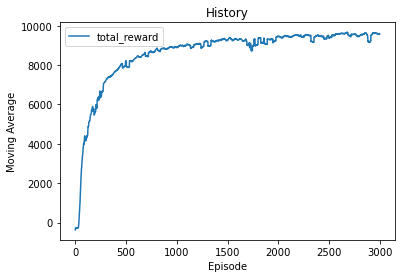

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(data, avg_span=30):
    fig1, ax1 = plt.subplots()
    for title, history in data:
        x = range(len(history))
        cumsum = np.cumsum(history)
        avgs = [cumsum[ep]/(ep+1) if ep<avg_span else (cumsum[ep]-cumsum[ep-avg_span])/avg_span for ep in x]
        ax1.plot(x, avgs, label=title)
    ax1.set_title("History")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Moving Average")
    ax1.legend()

plot([
    ('total_reward', history),
])